# Hair follicle (ATAC-seq + RNA-seq)

Modeling single-cell dynamics has opened new ways of analyzing cellular differentiation in single-cell data. The resulting transition probabilities between cells (velocities) try to reconstruct the underlying developmental differentiation processes. There are a few approaches to modeling single-cell velocities, usually based on RNA-seq, such as  [Velocyto](https://doi.org/10.1038/s41586-018-0414-6), [scVelo](https://www.nature.com/articles/s41587-020-0591-3), or [Waddington Optimal Transport](https://www.sciencedirect.com/science/article/pii/S009286741930039X). Ocelli can incorporate single-cell dynamics information when visualizing multimodal data. 

This tutorial investigates a single-cell multimodal hair follicle dataset from [Ma, Sai, et al. "Chromatin potential identified by shared single-cell profiling of RNA and chromatin." Cell 183.4 (2020): 1103-1116](https://www.sciencedirect.com/science/article/pii/S0092867420312538). The dataset consists of two single-cell modalities: ATAC-seq (chromatin accessibility, available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597)) and RNA-seq (gene expression, available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156608)). Data comes from female mouse dorsal skin, but we analyze a hair follicle subset here. During this tutorial, you will compute an MDM dataset representation and visualize it using additional RNA velocity information. 

Firstly, load the necessary packages.

In [2]:
import ocelli as oci
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import scrublet as scr

import anndata

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from os.path import join
from scipy.sparse import csr_matrix

# a path to the folder with data
folder_path = '../../../../data/hair-follicle'

SEED = 17

## Load and preprocess the data

Load the file with RNA-seq barcodes, ATAC-seq barcodes, and cell type annotations (available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597)).

In [2]:
celltypes = pd.read_csv(join(folder_path, 'GSM4156597_skin_celltype.txt'), sep='\t')

celltypes

atac.bc                   rna.bc           celltype
0      R1.01.R2.01.R3.06.P1.07  R1.01.R2.01.R3.06.P1.55  Dermal Fibroblast
1      R1.01.R2.03.R3.68.P1.07  R1.01.R2.03.R3.68.P1.55  Dermal Fibroblast
2      R1.01.R2.05.R3.15.P1.05  R1.01.R2.05.R3.15.P1.53  Dermal Fibroblast
3      R1.01.R2.05.R3.40.P1.07  R1.01.R2.05.R3.40.P1.55  Dermal Fibroblast
4      R1.01.R2.05.R3.49.P1.07  R1.01.R2.05.R3.49.P1.55  Dermal Fibroblast
...                        ...                      ...                ...
34769  R1.92.R2.79.R3.05.P1.08  R1.92.R2.79.R3.05.P1.56         Melanocyte
34770  R1.93.R2.20.R3.18.P1.05  R1.93.R2.20.R3.18.P1.53         Melanocyte
34771  R1.93.R2.80.R3.62.P1.07  R1.93.R2.80.R3.62.P1.55         Melanocyte
34772  R1.93.R2.91.R3.82.P1.08  R1.93.R2.91.R3.82.P1.56         Melanocyte
34773  R1.94.R2.75.R3.40.P1.07  R1.94.R2.75.R3.40.P1.55         Melanocyte

[34774 rows x 3 columns]

Keep cells from the hair follicle subpopulation, including transit-amplifying cells (TAC), inner root sheath (IRS) cells, medulla cells, and hair shaft cells.

In [3]:
celltypes = celltypes[celltypes.celltype.isin(['TAC-1', 'TAC-2', 'IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])].reset_index(drop=True)

celltypes

atac.bc                   rna.bc  \
0     R1.01.R2.01.R3.43.P1.08  R1.01.R2.01.R3.43.P1.56   
1     R1.01.R2.06.R3.83.P1.07  R1.01.R2.06.R3.83.P1.55   
2     R1.01.R2.11.R3.86.P1.08  R1.01.R2.11.R3.86.P1.56   
3     R1.01.R2.15.R3.09.P1.07  R1.01.R2.15.R3.09.P1.55   
4     R1.01.R2.17.R3.81.P1.05  R1.01.R2.17.R3.81.P1.53   
...                       ...                      ...   
7192  R1.96.R2.73.R3.72.P1.08  R1.96.R2.73.R3.72.P1.56   
7193  R1.96.R2.82.R3.52.P1.07  R1.96.R2.82.R3.52.P1.55   
7194  R1.96.R2.83.R3.68.P1.06  R1.96.R2.83.R3.68.P1.54   
7195  R1.96.R2.87.R3.63.P1.07  R1.96.R2.87.R3.63.P1.55   
7196  R1.96.R2.88.R3.36.P1.05  R1.96.R2.88.R3.36.P1.53   

                       celltype  
0                         TAC-1  
1                         TAC-1  
2                         TAC-1  
3                         TAC-1  
4                         TAC-1  
...                         ...  
7192  Hair Shaft-cuticle.cortex  
7193  Hair Shaft-cuticle.cortex  
7194  Hair Shaft-cuticle.cortex  
7195  Hair Shaft-cuticle.cortex  
7196  Hair Shaft-cuticle.cortex  

[7197 rows x 3 columns]

### RNA-seq preprocessing

We generated the gene expression count matrix by running [Velocyto](http://velocyto.org) on raw bam files available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156608). The resulting loom file has the RNA-seq count matrix (``rna_seq.X``), and its unspliced (``rna_seq.layers['unspliced']``) and spliced (``rna_seq.layers['spliced']``) layers.

Load the loom file.

In [4]:
rna_seq = sc.read_loom(join(folder_path, 'skin_XCISH.loom'))
rna_seq.var_names_make_unique()

Select the hair follicle subpopulation.

In [5]:
# Change RNA-seq barcodes so that they match ones from the celltypes DataFrame
rna_seq.obs.index = [index.split(':')[1].replace(',', '.') for index in rna_seq.obs.index]
rna_seq = rna_seq[celltypes['rna.bc']]

# Add celltype annotations
rna_seq.obs['celltype'] = list(celltypes['celltype'])

rna_seq

AnnData object with n_obs × n_vars = 7197 × 27998
    obs: 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

The count matrix has 7197 cells and 27998 genes.

Remove doublets using [Scrublet](https://www.sciencedirect.com/science/article/pii/S2405471218304745). The formula for the number of collisions is from [here](https://www.sciencedirect.com/science/article/pii/S0092867420312538).

In [6]:
D, N = 884736, rna_seq.shape[0]
n_collisions = N - D + D * (((D - 1) / D)**N)

scrublet = scr.Scrublet(rna_seq.X, expected_doublet_rate=n_collisions / N, random_state=SEED)
doublet_scores, predicted_doublets = scrublet.scrub_doublets()

threshold = np.percentile(doublet_scores, 100 * (1 - (n_collisions / N)))

rna_seq.obs['doublet_scores'] = doublet_scores
rna_seq = rna_seq[rna_seq.obs['doublet_scores'] < threshold]

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.05
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 0.4%
	Estimated  = 0.0%
Elapsed time: 4.6 seconds


Filter out low-quality cells and low-expressed genes.

In [7]:
sc.pp.filter_cells(rna_seq, min_genes=20)
scv.pp.filter_genes(rna_seq, min_shared_cells=20)

rna_seq

Filtered out 25523 genes that are detected in less than 20 cells (shared).


AnnData object with n_obs × n_vars = 7160 × 2475
    obs: 'celltype', 'doublet_scores', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

After all filterings, there are 7166 cells and 2486 genes. 

In the first step of dimension reduction, train an LDA topic model.

In [8]:
oci.pp.LDA(rna_seq, n_components=15, output_key='lda', verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LDA's cell-topic distributions are saved in ``rna_seq.obsm['lda']``.

In [9]:
rna_seq.obsm['lda'].shape

(7160, 15)

Prepare the count matrix for RNA velocity estimation. You need to perform the following steps:

- normalize the count matrix,
- select a subset of highly variable genes (RNA velocity is estimated only on them),
- logarithmize the count matrix.

In [10]:
scv.pp.normalize_per_cell(rna_seq, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(rna_seq, n_top_genes=1000)
scv.pp.log1p(rna_seq)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.


Compute [scVelo](https://www.biorxiv.org/content/10.1101/820936v1.full.pdf) RNA velocities.

In [11]:
scv.tl.velocity(rna_seq, mode='stochastic')
scv.tl.velocity_graph(rna_seq)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/7160 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


The RNA velocity graph is saved in ``rna_seq.uns['velocity_graph']`` as a square sparse `scipy.sparse.csr_matrix` of shape ``(n_cells, n_cells)``. It stores transitions between cells. A higher value translates to a higher transition probability between cells.

In [12]:
rna_seq.uns['velocity_graph']

<7160x7160 sparse matrix of type '<class 'numpy.float32'>'
	with 1242327 stored elements in Compressed Sparse Row format>

### ATAC-seq preprocessing

We generated the chromatin accessibility count matrix by running [Signac](https://stuartlab.org/signac/) on the fragments file available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597).

Load the resulting mtx file and transpose it, so rows and columns correspond to cells and genes.

In [13]:
atac_seq = sc.read_mtx(join(folder_path, 'fragments_matrix.mtx.gz'))
atac_seq = atac_seq.T

Load cell and gene metadata to ``atac_seq.obs`` and ``atac_seq.var``.

In [14]:
atac_seq.obs = pd.read_csv(join(folder_path, 'CellIDS.txt'), index_col='colnames(mat)')
atac_seq.var = pd.read_csv(join(folder_path, 'genes.txt'), index_col='rownames(mat)')

Select prefiltered cells from RNA-seq.

In [15]:
celltypes.index = list(celltypes['rna.bc'])
celltypes.loc[rna_seq.obs.index]['atac.bc']

atac_seq_barcodes = celltypes.loc[rna_seq.obs.index]['atac.bc']
atac_seq = atac_seq[atac_seq_barcodes]

In [16]:
c = atac_seq.copy()

Filter out low-expressed genes.

In [17]:
sc.pp.filter_genes(atac_seq, min_cells=20)

Compute LDA topics.

In [18]:
oci.pp.LDA(atac_seq, n_components=15, output_key='lda', verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

### Prepare AnnData object for MDM training

Combine preprocessed RNA-seq and ATAC-seq data into a single ``anndata.AnnData`` object.

In [19]:
adata = anndata.AnnData(csr_matrix(np.zeros(rna_seq.shape)))

# Cell metadata
adata.obs = rna_seq.obs
# LDA embeddings
adata.obsm['rna_seq'] = rna_seq.obsm['lda']
adata.obsm['atac_seq'] = atac_seq.obsm['lda']
# RNA velocity transitions
adata.uns['velocity_graph'] = rna_seq.uns['velocity_graph']
adata.layers['velocity'] = rna_seq.layers['velocity']
# Modality list
adata.uns['modalities'] = ['rna_seq', 'atac_seq']

adata.write(join(folder_path, 'hf.h5ad'), compression='gzip', compression_opts=9)

## Multimodal Diffusion Maps

Follow the usual MDM workflow: calculate nearest neighbors, multimodal weights, and the low-dimensional MDM embedding.

In [64]:
adata = anndata.read_h5ad(join(folder_path, 'hf.h5ad'))

oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=20, random_state=SEED, verbose=True)

[rna_seq]	20 nearest neighbors calculated.
[atac_seq]	20 nearest neighbors calculated.


2022-11-13 15:43:12,142	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2022-11-13 15:43:17,666	INFO worker.py:1518 -- Started a local Ray instance.


[rna_seq]	Unimodal Markov chain calculated.
[atac_seq]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.


## Velocity-based representation

Ocelli can incorporate RNA velocity into the visualizations when constructing the graph for ForceAtlas2. `oci.tl.velocity_graph` builds the graph by calculating nearest neighbors in the MDM latent space and finding `n_edges` neighbors with the highest transition probabilities. Edges connect MDM's nearest neighbors if there are less than `n_edges` non-zero probabilities.

While MDM neighbors define the global multimodal structure, RNA velocity information aligns cells locally along the velocity stream.

In [65]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.velocity_graph(adata, n_edges=3, neighbors_key='X_mdm', verbose=True)

[X_mdm]	100 nearest neighbors calculated.
RNA velocity-based graph constructed.


Compute the ForceAtlas2 3D representation. 3D plots can capture more complex structures, which may get squished in 2D.

In [66]:
oci.tl.FA2(adata, n_components=3, output_key='X_fa2', random_state=SEED)

Nov 13, 2022 3:43:33 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Nov 13, 2022 3:43:33 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 7,160 (7,160 added)
Nov 13, 2022 3:43:33 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 21,480 (20,947 added)


*************************25%
*************************50%
*

************************75%
*************************100%
Time = 58.989s


We recommend generating a 3D interactive plot, which you can save as an html file.

**All 3D plots from this tutorial are available on [GitHub](https://github.com/TabakaLab/ocelli/html) in the `Hair follicle` folder.**

In [67]:
plot = oci.pl.scatter(adata, x_key='X_fa2', color_key='celltype', marker_size=2, method='plotly')
plot.write_html(join(folder_path, 'Celltypes.html'))

Alternatively, create 2D projections of the ForceAtlas2 3D embedding.

(<Figure size 1920x1440 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'alpha=0 beta=0'}>,
         <AxesSubplot:title={'center':'alpha=0 beta=45'}>,
         <AxesSubplot:title={'center':'alpha=0 beta=90'}>,
         <AxesSubplot:title={'center':'alpha=0 beta=135'}>],
        [<AxesSubplot:title={'center':'alpha=45 beta=0'}>,
         <AxesSubplot:title={'center':'alpha=45 beta=45'}>,
         <AxesSubplot:title={'center':'alpha=45 beta=90'}>,
         <AxesSubplot:title={'center':'alpha=45 beta=135'}>],
        [<AxesSubplot:title={'center':'alpha=90 beta=0'}>,
         <AxesSubplot:title={'center':'alpha=90 beta=45'}>,
         <AxesSubplot:title={'center':'alpha=90 beta=90'}>,
         <AxesSubplot:title={'center':'alpha=90 beta=135'}>],
        [<AxesSubplot:title={'center':'alpha=135 beta=0'}>,
         <AxesSubplot:title={'center':'alpha=135 beta=45'}>,
         <AxesSubplot:title={'center':'alpha=135 beta=90'}>,
         <AxesSubplot:title={'center':'alpha=135 beta=135'}>

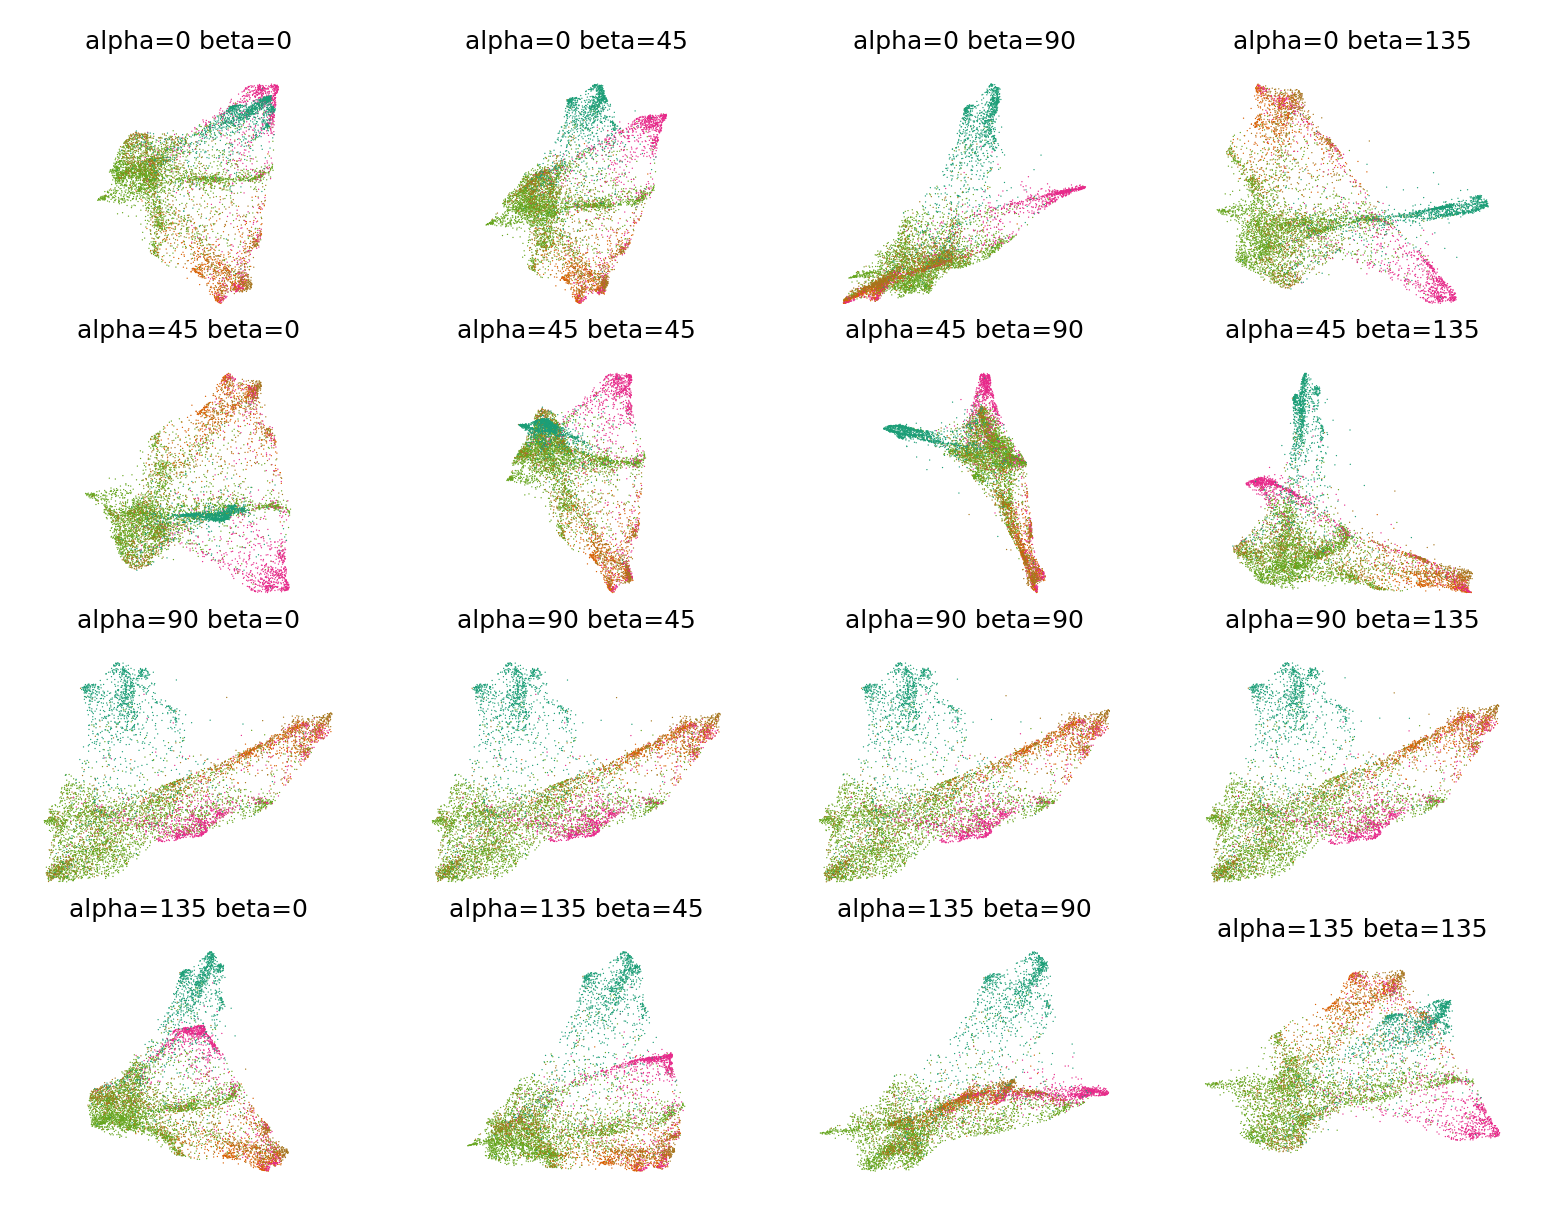

In [68]:
oci.pl.perspectives(adata, x_key='X_fa2', color_key='celltype', cmap='Dark2', marker_size=0.1, random_state=SEED)

The polar coordinates `alpha` and `beta` define the projection plane. Here, we select `alpha=0` and `beta=135`.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

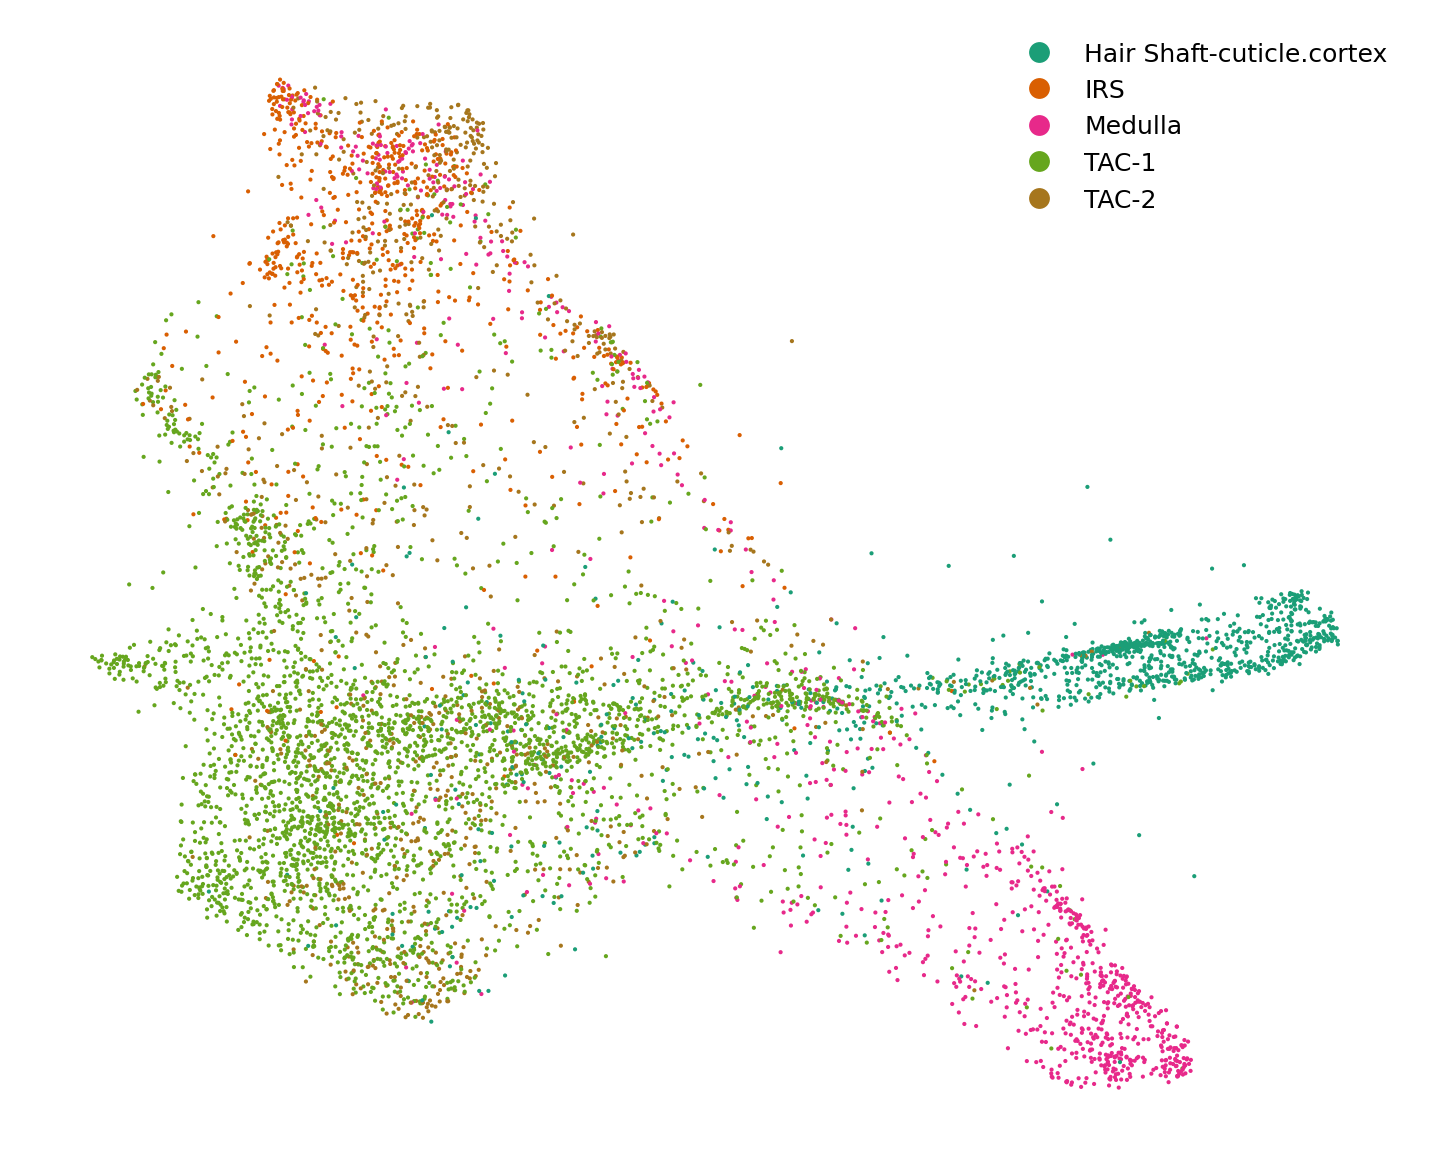

In [69]:
oci.tl.project_2d(adata, x_key='X_fa2', output_key='X_proj', alpha=0, beta=135, random_state=SEED)
oci.pl.scatter(adata, x_key='X_proj', color_key='celltype', cmap='Dark2', marker_size=1)

Visualize the velocity stream.

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_proj', embedded velocity vectors (adata.obsm)


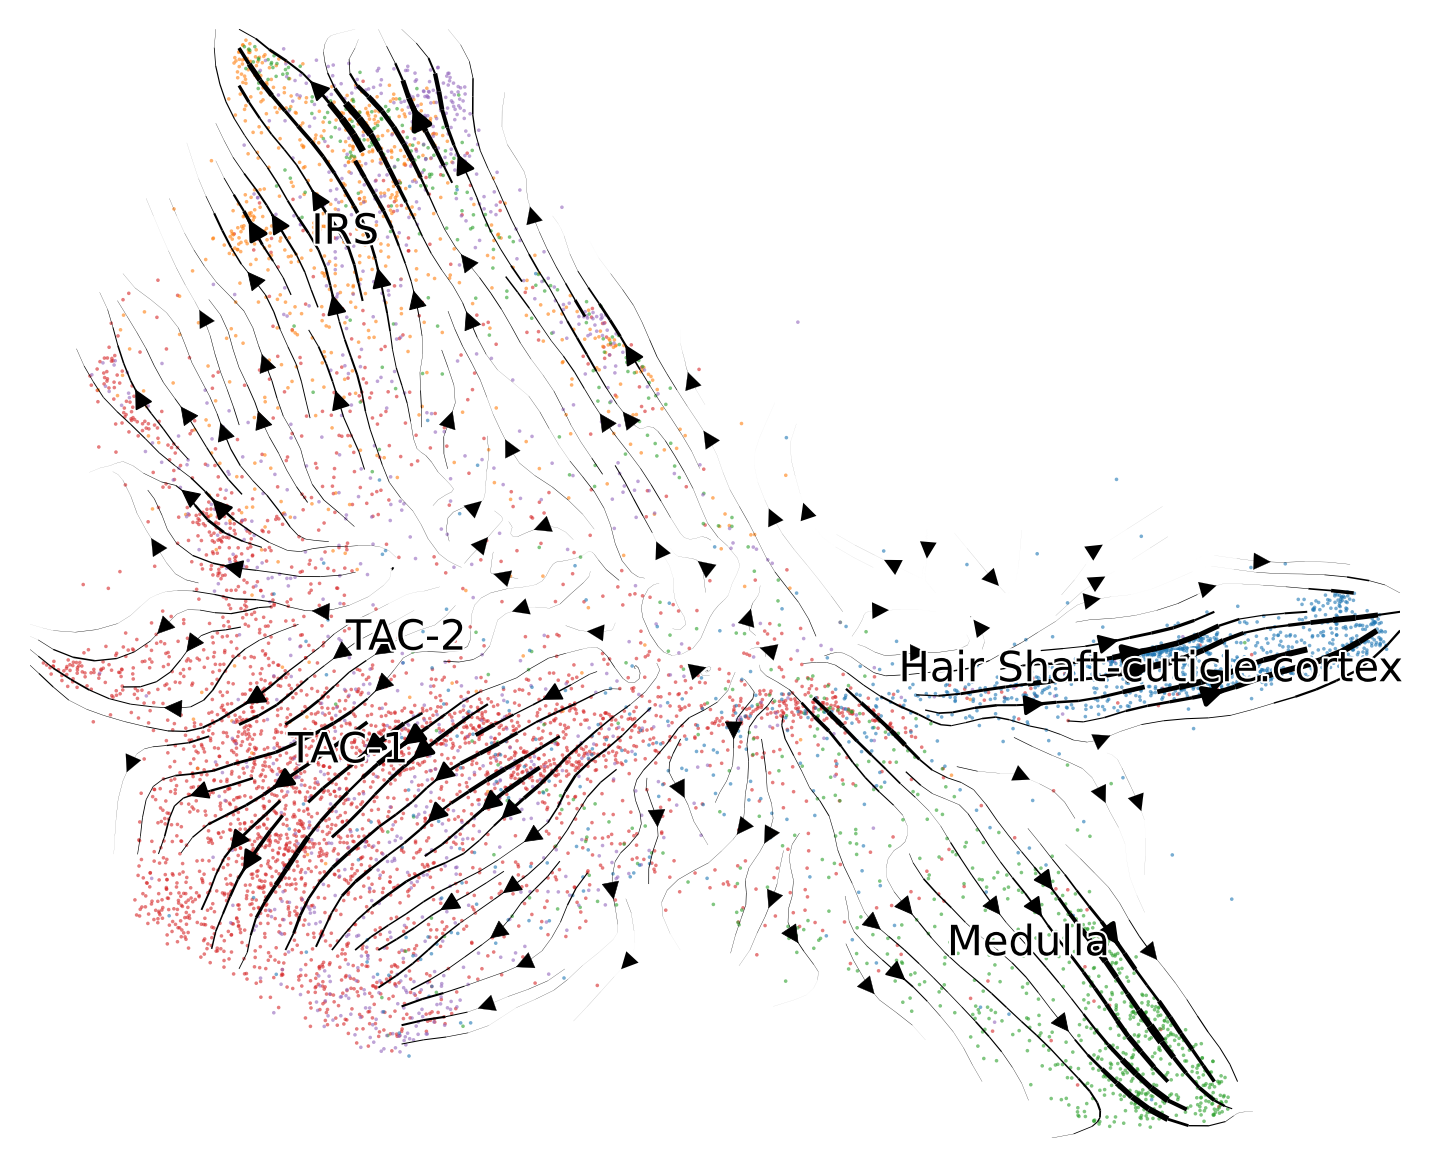

In [70]:
fig, ax = plt.subplots()
scv.pl.velocity_embedding_stream(adata, basis='proj', alpha=0.6, 
                                 title='', dpi=200, density=2, 
                                 linewidth=1, show=False, ax=ax, 
                                 color='celltype', size=3, 
                                 legend_fontweight=1)
ax.set_aspect('equal')

## Multimodal weights distribution

Generate 3D scatter plots showing multimodal weights' modality-specific distributions.

In [72]:
# Plotly colormap
cmap = [(0, '#EAEAEA'), (0.25, '#EAEAEA'), (0.5, '#EFB0B0'), (0.75, '#FF0000'), (1, '#FF0000')]

# Save ATAC-seq weights to adata.obs and use them as a color scheme

adata.obs['w_atac'] = list(adata.obsm['weights']['atac_seq'])
plot = oci.pl.scatter(adata, x_key='X_fa2', color_key='w_atac', marker_size=2, method='plotly', vmin=0, vmax=1, cmap=cmap)
plot.write_html(join(folder_path, 'ATAC-seq weights.html'))

# Repeat for RNA-seq

adata.obs['w_rna'] = list(adata.obsm['weights']['rna_seq'])
plot = oci.pl.scatter(adata, x_key='X_fa2', color_key='w_rna', marker_size=2, method='plotly', vmin=0, vmax=1, cmap=cmap)
plot.write_html(join(folder_path, 'RNA-seq weights.html'))

In some cases, investigating multimodal weights on scatter plots may take much work. As an alternative, Ocelli's `oci.pl.weights_per_cluster` method calculates Louvain clusters in the MDM latent space and corresponding cluster-specific median or mean weights. Looking at weights at the cluster level removes noise present at the cell level while preserving distribution.

[X_mdm]	Louvain clusters computed.


(<Figure size 1920x1440 with 1 Axes>,
 <AxesSubplot:xlabel='Cluster', ylabel='median weight in cluster'>)

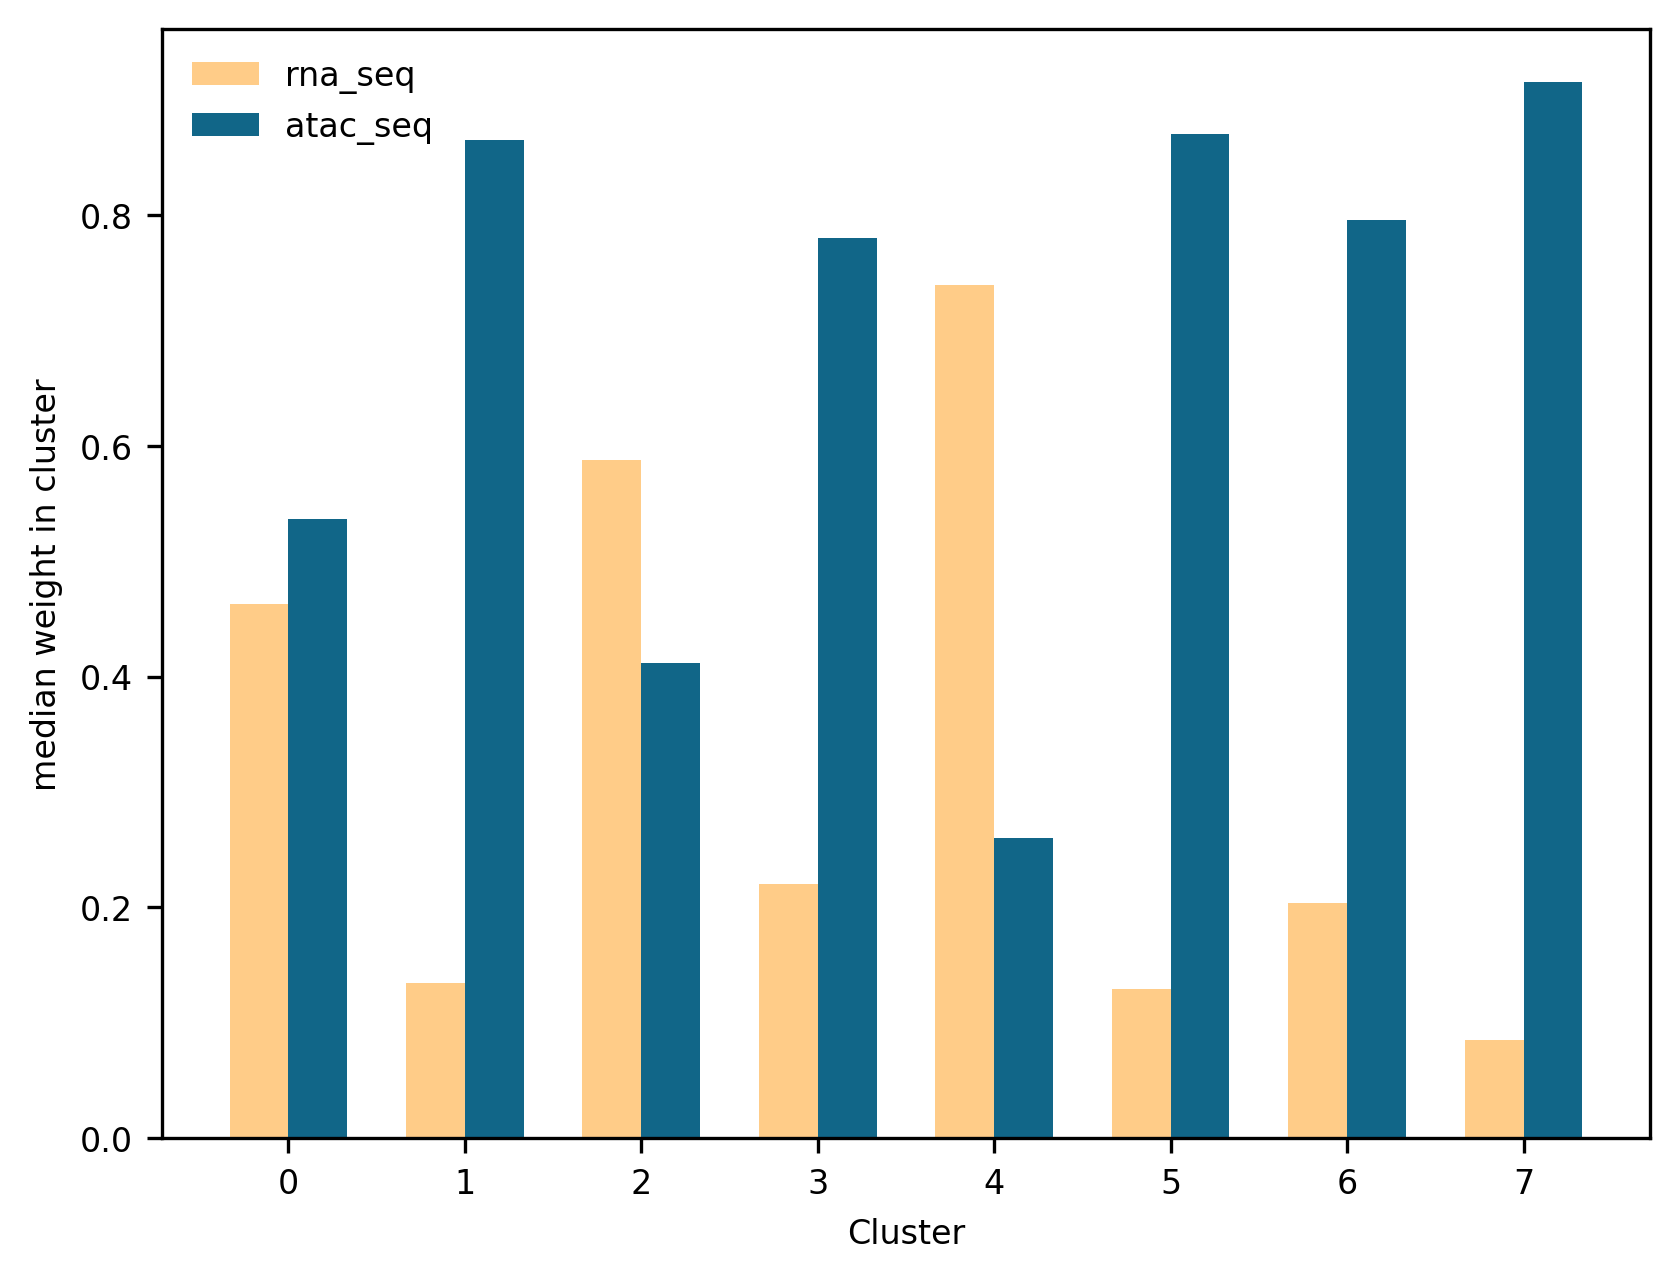

In [73]:
cmap_bar = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#FFCC88', '#116688'], N=2)

oci.pl.weights_per_cluster(adata, x_key='X_mdm', resolution=0.5, fontsize=8, cmap=cmap_bar, verbose=True, random_state=SEED)

The above plot is valid only when looking at the cluster distribution. We suggest generating an interactive 3D visualization with Louvain labels.

In [74]:
plot = oci.pl.scatter(adata, x_key='X_fa2', color_key='louvain', marker_size=2, method='plotly')
plot.write_html(join(folder_path, 'Louvain clusters.html'))

As an alternative, generate a 2D plot.

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

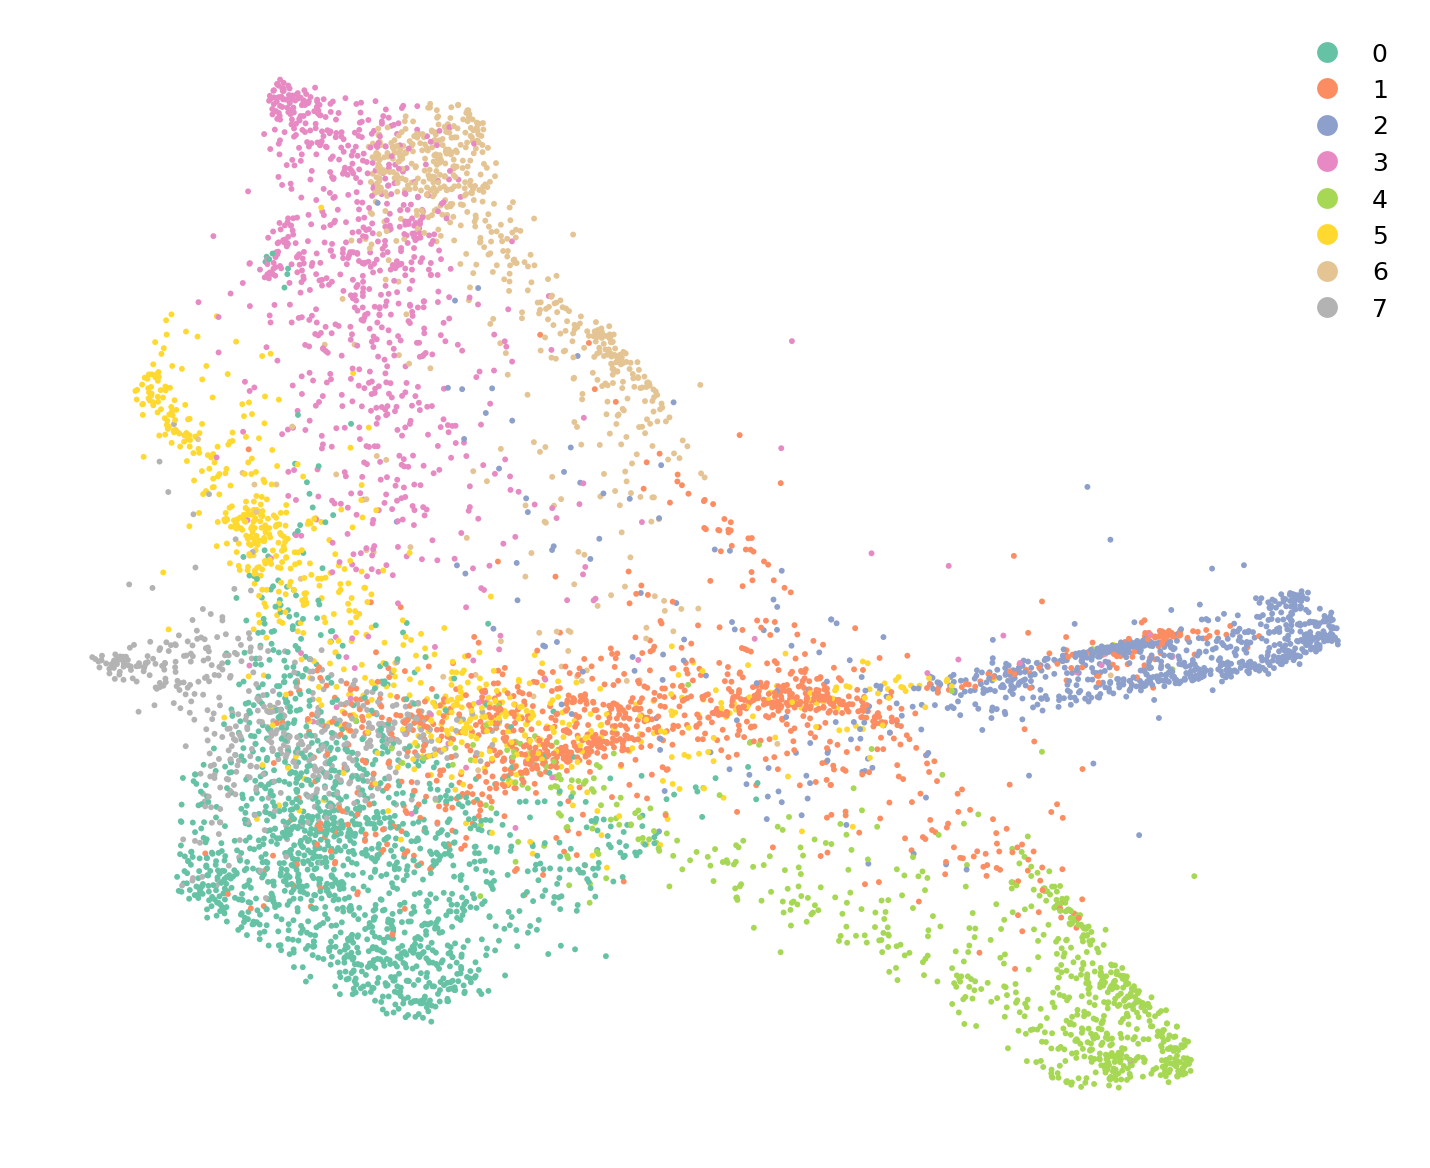

In [75]:
oci.pl.scatter(adata, x_key='X_proj', color_key='louvain', cmap='Set2', marker_size=2)

The conclusion to multimodal weights analysis is that while RNA-seq weights tend to be higher for developmental fates (dominantly in medulla and hair shaft), ATAC-seq dominates in developing cells.

## Topic evaluation

Investigate the topic quality by plotting cell-topic LDA distributions.

Firstly, for gene expression.

(<Figure size 1920x1440 with 30 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>],
        [<AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'5'}>],
        [<AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>],
        [<AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>],
        [<AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>]], dtype=object))

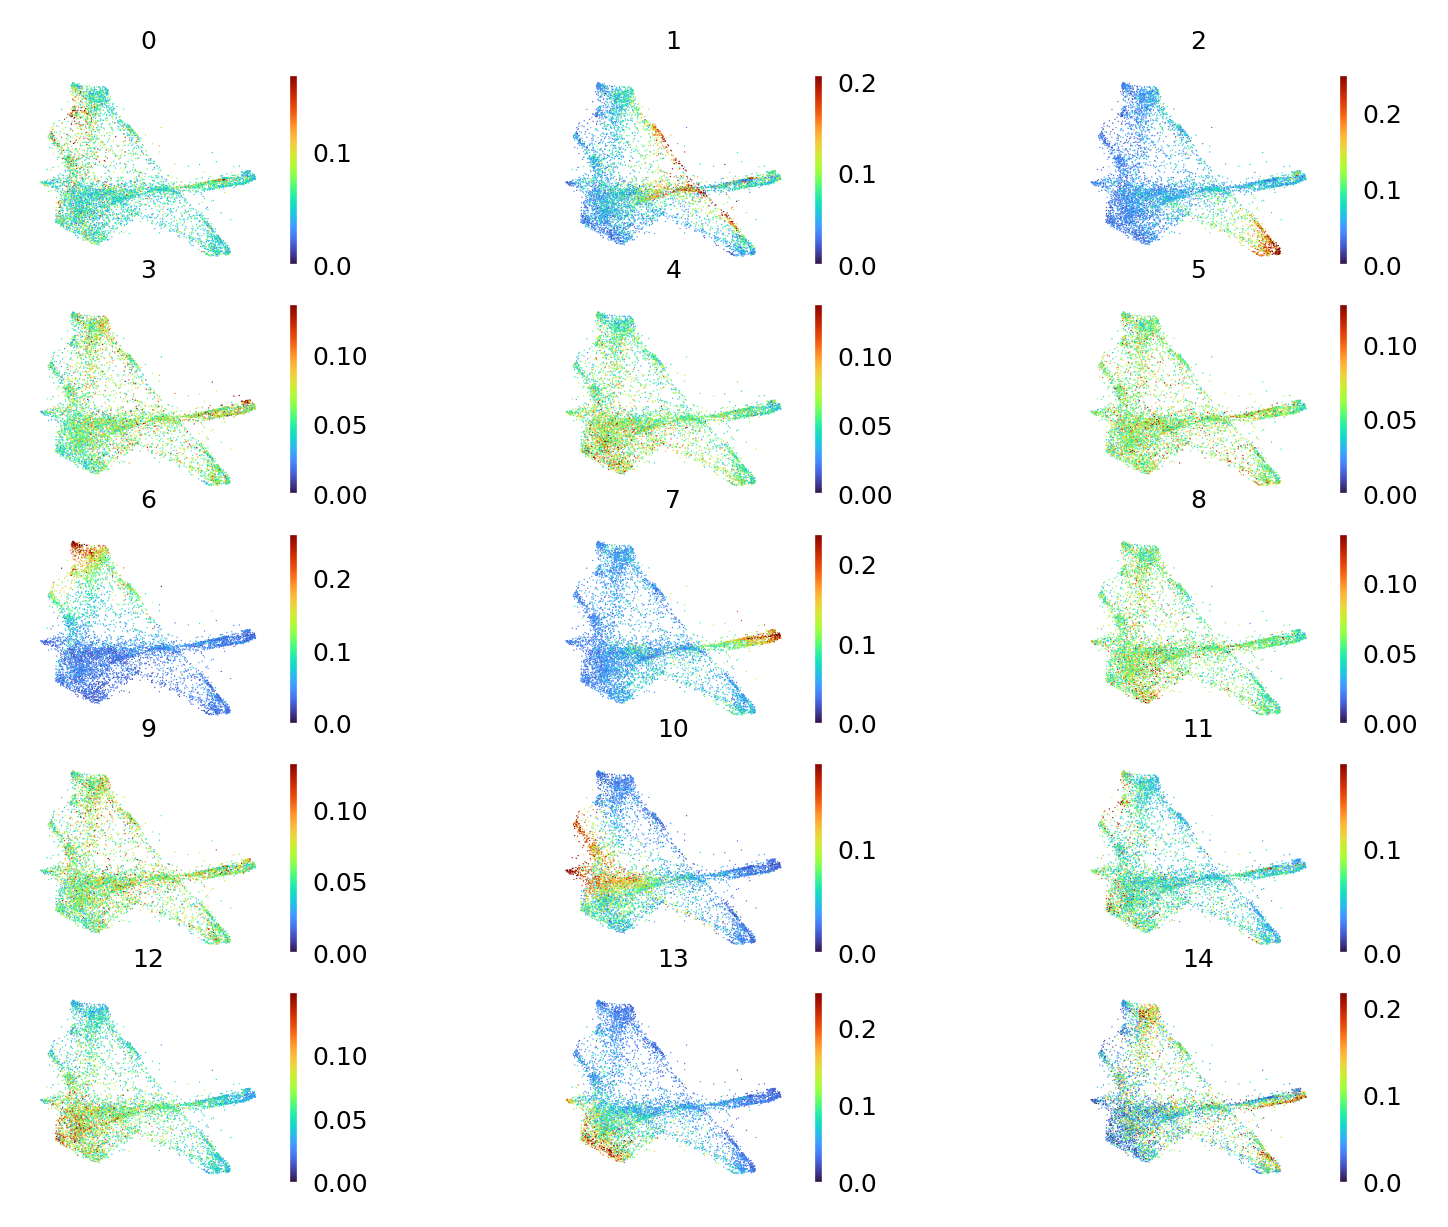

In [76]:
oci.pl.scatter(adata, x_key='X_proj', color_key='rna_seq', cmap='turbo', marker_size=0.1, vmin=0, max_columns=3)

Secondly, for chromatin accessibility.

(<Figure size 1920x1440 with 30 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>],
        [<AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'5'}>],
        [<AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>],
        [<AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>],
        [<AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>]], dtype=object))

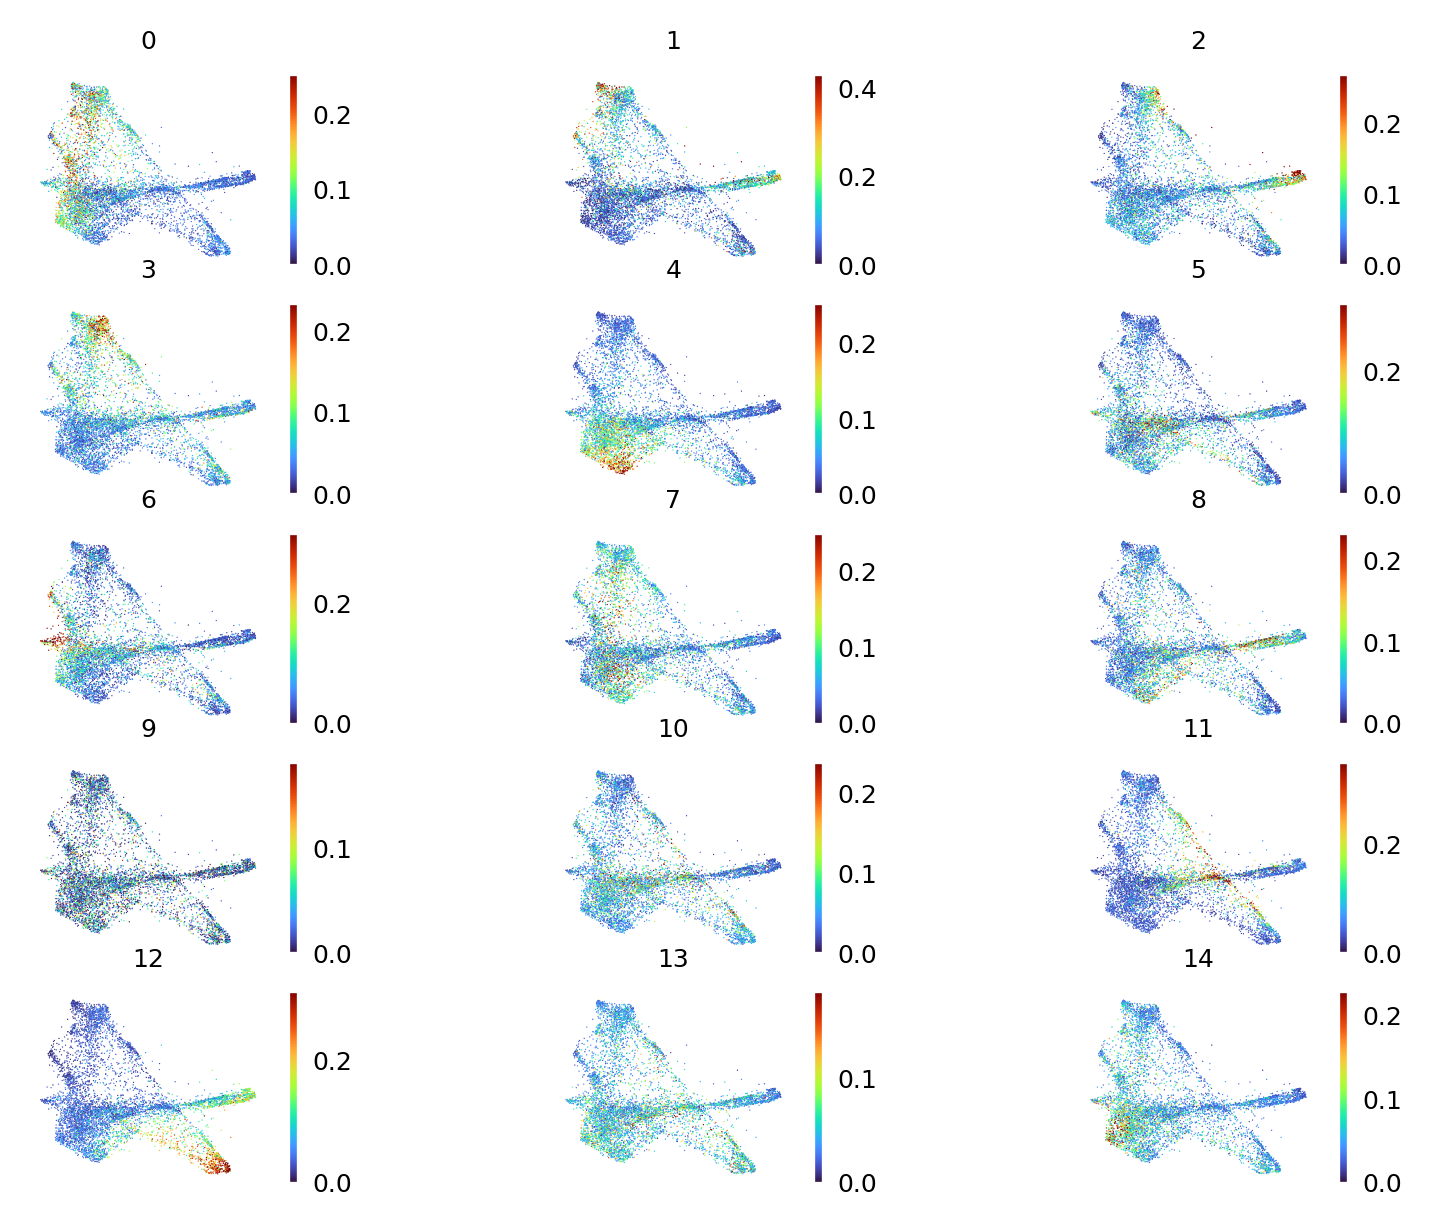

In [77]:
oci.pl.scatter(adata, x_key='X_proj', color_key='atac_seq', cmap='turbo', marker_size=0.1, vmin=0, max_columns=3)

## Gene signature analysis

In the previous tutorial, you analyzed marker activity in the human bone marrow dataset. Here, you will analyze gene signatures using z-scores, a statistic quantifying how much values diverge from the mean concerning its standard deviation. A high z-score indicates that a gene is expressed above mean. You can interpret a gene signature as a set of markers. We calculate z-scores for each marker individually and then average them.

For z-score calculation, normalize, and logarithmize the raw gene expression count matrix.

In [78]:
# Load the count matrix
rna_sig = sc.read_loom(join(folder_path, 'skin_XCISH.loom'))
rna_sig.var_names_make_unique()

# Select the hair follicle subset
rna_sig.obs.index = [index.split(':')[1].replace(',', '.') for index in rna_sig.obs.index]
rna_sig = rna_sig[adata.obs.index]

# Preprocess the count matrix
sc.pp.normalize_total(rna_sig, target_sum=10000)
sc.pp.log1p(rna_sig)

Ocelli's `oci.tl.mean_z_scores` calculates mean z-scores of a specified signature. It takes as input a list of indices of count matrix columns corresponding to signature genes. The function below converts a list of `str` gene names into a list of `rna_sig.var` indices.

In [79]:
rna_vars = list(rna_sig.var.index)

def get_signature_indices(signature, var_names):
    signature_indices = list()
    
    for gene in signature:
        if gene in var_names:
            signature_indices.append(var_names.index(gene))
            
    return signature_indices

The hair follicle was studied in detail [here](https://www.sciencedirect.com/science/article/pii/S0092867417303677). In hair follicle, TACs, transit amplifying cells produce the hair shaft and its channel, the inner root sheath (IRS). Below, we investigate the abovementioned cell types using z-scores of gene signatures. While presented plots are 2D, we strongly recommend We use hair follicle gene signatures from [here](https://www.sciencedirect.com/science/article/pii/S0092867417303677) and the proliferation signature from [here](https://www.sciencedirect.com/science/article/pii/S009286741930039X).

### Hair shaft (HS)

In [80]:
signature_cmap = [(0, "blue"), (0.5, "white"), (1, "red")]

In [88]:
signature_name = 'Hair shaft - Medulla (2-a)'
signature = list(pd.read_csv(join(folder_path, 'signature-2a.csv'), index_col=0).index)

oci.tl.mean_z_scores(rna_sig, markers=get_signature_indices(signature, rna_vars), output_key=signature_name, vmin=-5, vmax=5)
adata.obs[signature_name] = rna_sig.obs[signature_name]

plot = oci.pl.scatter(adata, x_key='X_fa2', 
                      color_key=signature_name, marker_size=2, method='plotly', vmin=-0.5, vmax=0.5, 
                      cmap=signature_cmap)
plot.write_html(join(folder_path, '{}.html'.format(signature_name)))

2022-11-13 15:47:27,831	INFO worker.py:1518 -- Started a local Ray instance.


In [89]:
signature_name = 'Hair shaft - Cortex (2-b)'
signature = list(pd.read_csv(join(folder_path, 'signature-2b.csv'), index_col=0).index)

oci.tl.mean_z_scores(rna_sig, markers=get_signature_indices(signature, rna_vars), output_key=signature_name, vmin=-5, vmax=5)
adata.obs[signature_name] = rna_sig.obs[signature_name]

plot = oci.pl.scatter(adata, x_key='X_fa2', 
                      color_key=signature_name, marker_size=2, method='plotly', vmin=-0.5, vmax=0.5, 
                      cmap=signature_cmap)
plot.write_html(join(folder_path, '{}.html'.format(signature_name)))

2022-11-13 15:47:34,503	INFO worker.py:1518 -- Started a local Ray instance.


In [90]:
signature_name = 'Hair shaft - Cuticle (2-c)'
signature = list(pd.read_csv(join(folder_path, 'signature-2c.csv'), index_col=0).index)

oci.tl.mean_z_scores(rna_sig, markers=get_signature_indices(signature, rna_vars), output_key=signature_name, vmin=-5, vmax=5)
adata.obs[signature_name] = rna_sig.obs[signature_name]

plot = oci.pl.scatter(adata, x_key='X_fa2', 
                      color_key=signature_name, marker_size=2, method='plotly', vmin=-0.5, vmax=0.5, 
                      cmap=signature_cmap)
plot.write_html(join(folder_path, '{}.html'.format(signature_name)))

2022-11-13 15:47:41,348	INFO worker.py:1518 -- Started a local Ray instance.


### Inner root sheath (IRS)

In [91]:
signature_name = 'Inner root sheath - Cuticle, Huxley\'s (2-d)'
signature = list(pd.read_csv(join(folder_path, 'signature-2d.csv'), index_col=0).index)

oci.tl.mean_z_scores(rna_sig, markers=get_signature_indices(signature, rna_vars), output_key=signature_name, vmin=-5, vmax=5)
adata.obs[signature_name] = rna_sig.obs[signature_name]

plot = oci.pl.scatter(adata, x_key='X_fa2', 
                      color_key=signature_name, marker_size=2, method='plotly', vmin=-0.5, vmax=0.5, 
                      cmap=signature_cmap)
plot.write_html(join(folder_path, '{}.html'.format(signature_name)))

2022-11-13 15:47:49,210	INFO worker.py:1518 -- Started a local Ray instance.


In [92]:
signature_name = 'Inner root sheath - Cuticle, Huxley\'s (2-e)'
signature = list(pd.read_csv(join(folder_path, 'signature-2e.csv'), index_col=0).index)

oci.tl.mean_z_scores(rna_sig, markers=get_signature_indices(signature, rna_vars), output_key=signature_name, vmin=-5, vmax=5)
adata.obs[signature_name] = rna_sig.obs[signature_name]

plot = oci.pl.scatter(adata, x_key='X_fa2', 
                      color_key=signature_name, marker_size=2, method='plotly', vmin=-0.5, vmax=0.5, 
                      cmap=signature_cmap)
plot.write_html(join(folder_path, '{}.html'.format(signature_name)))

2022-11-13 15:47:56,978	INFO worker.py:1518 -- Started a local Ray instance.


In [93]:
signature_name = 'Inner root sheath - Henle\'s (2-f)'
signature = list(pd.read_csv(join(folder_path, 'signature-2f.csv'), index_col=0).index)

oci.tl.mean_z_scores(rna_sig, markers=get_signature_indices(signature, rna_vars), output_key=signature_name, vmin=-5, vmax=5)
adata.obs[signature_name] = rna_sig.obs[signature_name]

plot = oci.pl.scatter(adata, x_key='X_fa2', 
                      color_key=signature_name, marker_size=2, method='plotly', vmin=-0.5, vmax=0.5, 
                      cmap=signature_cmap)
plot.write_html(join(folder_path, '{}.html'.format(signature_name)))

2022-11-13 15:48:05,724	INFO worker.py:1518 -- Started a local Ray instance.


### Proliferation

In [94]:
signature_name = 'Proliferation'
signature = list(pd.read_csv(join(folder_path, 'signature-proliferation.csv'), index_col=0).index)

oci.tl.mean_z_scores(rna_sig, markers=get_signature_indices(signature, rna_vars), output_key=signature_name, vmin=-5, vmax=5)
adata.obs[signature_name] = rna_sig.obs[signature_name]

plot = oci.pl.scatter(adata, x_key='X_fa2', 
                      color_key=signature_name, marker_size=2, method='plotly', vmin=-0.5, vmax=0.5, 
                      cmap=signature_cmap)
plot.write_html(join(folder_path, '{}.html'.format(signature_name)))

2022-11-13 15:48:11,801	INFO worker.py:1518 -- Started a local Ray instance.
